In [1]:
import scanpy as sc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import scanpy.external as sce
from collections import Counter

In [2]:
def prepare_adata(directory):
    '''Return an adata object from a directory path'''

    matrix_file = directory + "/raw/matrix.mtx.gz"
    features_file = directory + "/raw/features.tsv.gz"
    barcodes_file = directory + "/raw/barcodes.tsv.gz"

    adata = sc.read_mtx(matrix_file)
    adata = adata.transpose()

    # add adata var
    adata_var = pd.read_csv(features_file, index_col = 0, delim_whitespace=True, header=None)
    adata_var.columns = ["gene_name", "drop1", "drop2"]
    adata_var = adata_var.reset_index().rename(columns = {0: 'ensembl_id'})
    adata_var = adata_var[["gene_name", "ensembl_id"]]
    adata.var = adata_var
    adata.var_names = adata.var['gene_name'].astype(str)
    adata.var = adata.var.drop(columns = ['gene_name'])
    adata.var_names_make_unique()

    # add barcodes
    adata_obs = pd.read_csv(barcodes_file, index_col = 0, delim_whitespace =True, header=None)
    adata_obs = adata_obs.reset_index().rename(columns = {0: 'barcode'})
    adata.obs = adata_obs
    adata.obs['donor_id'] = directory
    adata.obs_names = adata_obs.barcode
    adata.obs = adata.obs.drop(columns = ['barcode'])

    # filter adata to remove spike-ins or nan
    adata = adata[:,(~adata.var.index.str.startswith("gSpikein") & ~adata.var.index.str.startswith("nan"))]  
    
    return(adata)

In [3]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

In [4]:
matrix_directories = [d for d in os.listdir() if d.startswith("ENC")]
matrix_directories

['ENCFF802AQC',
 'ENCFF248EWR',
 'ENCFF849ALE',
 'ENCFF775ANN',
 'ENCFF805YRY',
 'ENCFF727JRO',
 'ENCFF069ATM',
 'ENCFF776DQR',
 'ENCFF684YRB']

In [5]:
%%time
# test one example
adata = prepare_adata(matrix_directories[0])

CPU times: user 15.1 s, sys: 1.49 s, total: 16.6 s
Wall time: 16.7 s


In [6]:
adata.obs.head()

,donor_id
barcode,
AAACAGCCAAACAACA,ENCFF802AQC
AAACAGCCAAACATAG,ENCFF802AQC
AAACAGCCAAACCCTA,ENCFF802AQC
AAACAGCCAAACCTAT,ENCFF802AQC
AAACAGCCAAACCTTG,ENCFF802AQC


In [7]:
adata.obs_names = adata.obs['donor_id'] + ":" + adata.obs_names

In [8]:
%%time
adata_list = list()

for matrix_directory in matrix_directories:
    print(matrix_directory, flush=True)
    subset_adata = prepare_adata(matrix_directory)

    #sc.pp.filter_genes(subset_adata, min_cells = 10)
    sc.pp.filter_cells(subset_adata, min_genes = 500)
    
    print(subset_adata.shape)
    adata_list.append(subset_adata)

adata = sc.concat(adata_list)

ENCFF802AQC


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(3905, 58780)
ENCFF248EWR


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(16324, 58780)
ENCFF849ALE


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(19526, 58780)
ENCFF775ANN


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(17007, 58780)
ENCFF805YRY


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(5371, 58780)
ENCFF727JRO


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(9878, 58780)
ENCFF069ATM


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(23669, 58780)
ENCFF776DQR


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(7741, 58780)
ENCFF684YRB


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(7935, 58780)
CPU times: user 6min 10s, sys: 43.4 s, total: 6min 54s
Wall time: 6min 55s


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
adata.obs_names = adata.obs['donor_id'] + ":" + adata.obs_names

### Add additional information to metadata

In [10]:
metadata = adata.obs[['donor_id']]

donor_metadata = pd.read_csv("00_fetal_multiome_metadata.txt", index_col = 0, delim_whitespace=True)
donor_metadata = donor_metadata[["RNA_adata_accession", "age", "sex", "region"]]
donor_metadata = donor_metadata.rename(columns = {"RNA_adata_accession": "donor_id"})
metadata = metadata.reset_index().merge(donor_metadata, on = "donor_id")
# add additional metadata columns
metadata['study'] = 'ENCODE v4 (Snyder)'
metadata['technology'] = 'Multiome-v1'
metadata['cell_or_nuclei'] = 'Nuclei'

metadata.index = metadata['index']
metadata = metadata.drop(columns = "index")

adata = adata[metadata.index, :]
adata.obs = metadata
adata.obs.head()

,donor_id,age,sex,region,study,technology,cell_or_nuclei
index,,,,,,,
ENCFF802AQC:AAACAGCCAAGCTACC,ENCFF802AQC,94,M,WH,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCFF802AQC:AAACAGCCACATTGCA,ENCFF802AQC,94,M,WH,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCFF802AQC:AAACATGCAATCCCTT,ENCFF802AQC,94,M,WH,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCFF802AQC:AAACATGCAGCAACAG,ENCFF802AQC,94,M,WH,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCFF802AQC:AAACATGCAGGCGAGT,ENCFF802AQC,94,M,WH,ENCODE v4 (Snyder),Multiome-v1,Nuclei


In [11]:
adata.layers["counts"] = adata.X

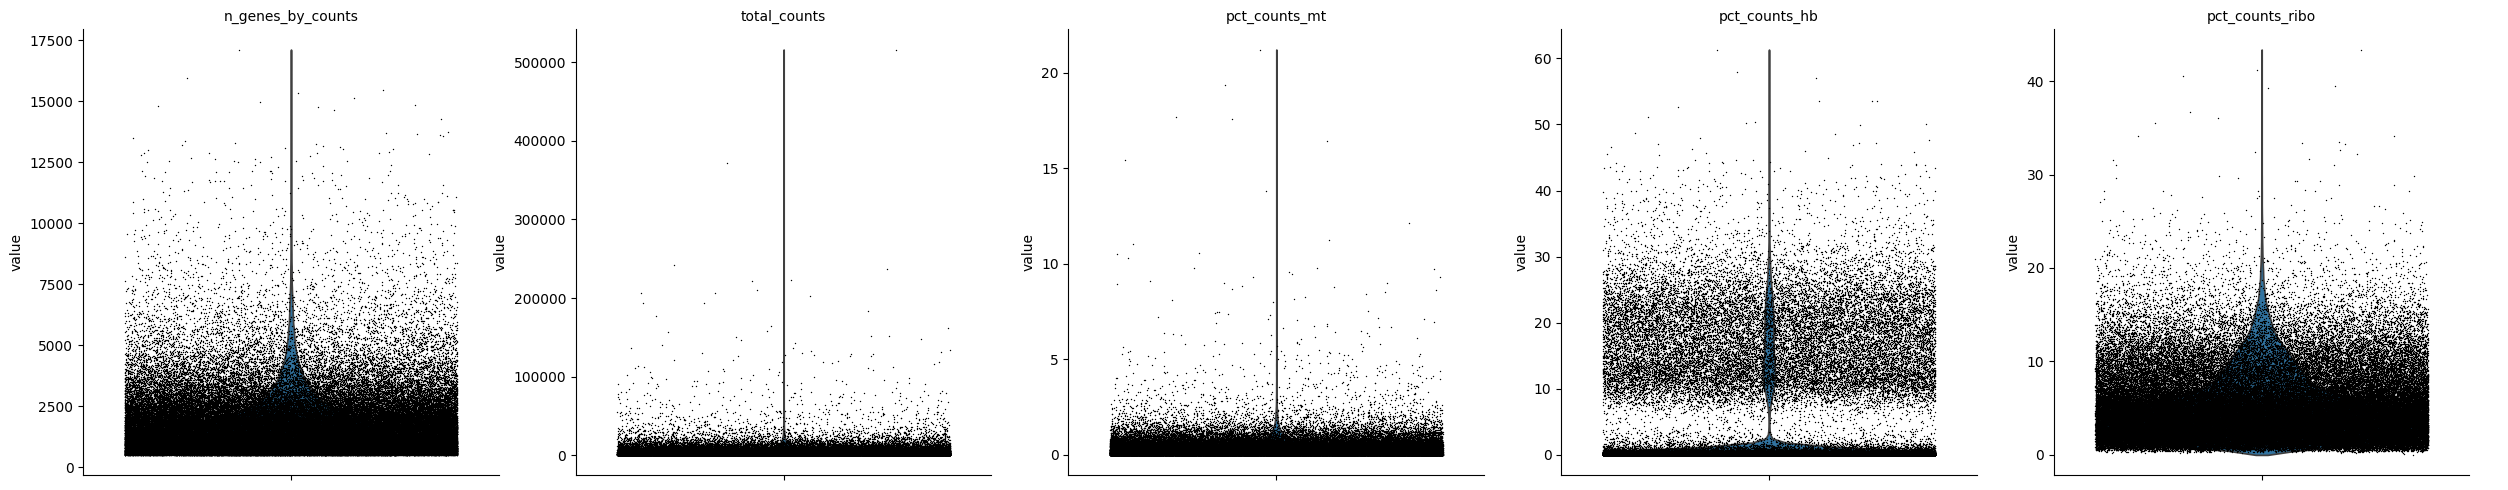

In [12]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"],
             jitter=0.4,
             multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 15.0
ribo_threshold = 15.0
hb_threshold = 5.0

In [13]:
adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

Filtered out 25678 cells


In [14]:
Counter(adata.obs.donor_id)

Counter({'ENCFF849ALE': 19043,
         'ENCFF775ANN': 16642,
         'ENCFF248EWR': 16230,
         'ENCFF727JRO': 9524,
         'ENCFF776DQR': 7612,
         'ENCFF684YRB': 7442,
         'ENCFF805YRY': 5316,
         'ENCFF802AQC': 3839,
         'ENCFF069ATM': 30})

### Remove the donor that only has 30 high quality nuclei

In [15]:
adata = adata[adata.obs.donor_id != "ENCFF069ATM", :].copy()

In [16]:
Counter(adata.obs.donor_id)

Counter({'ENCFF849ALE': 19043,
         'ENCFF775ANN': 16642,
         'ENCFF248EWR': 16230,
         'ENCFF727JRO': 9524,
         'ENCFF776DQR': 7612,
         'ENCFF684YRB': 7442,
         'ENCFF805YRY': 5316,
         'ENCFF802AQC': 3839})

In [17]:
%%time 

donor_key = "donor_id"
# predict the doublets with scrublet
print("Performing scrublet analysis...")
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Performing scrublet analysis...
Filtered out 11619 likely doublets
CPU times: user 20min 15s, sys: 14min 59s, total: 35min 15s
Wall time: 10min 3s


2025-01-01 14:54:36,716 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-01 14:54:41,284 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-01 14:54:41,656 - harmonypy - INFO - Iteration 1 of 10
2025-01-01 14:55:05,182 - harmonypy - INFO - Iteration 2 of 10
2025-01-01 14:55:37,790 - harmonypy - INFO - Iteration 3 of 10
2025-01-01 14:56:07,627 - harmonypy - INFO - Iteration 4 of 10
2025-01-01 14:56:19,863 - harmonypy - INFO - Iteration 5 of 10
2025-01-01 14:56:42,132 - harmonypy - INFO - Iteration 6 of 10
2025-01-01 14:57:04,863 - harmonypy - INFO - Iteration 7 of 10
2025-01-01 14:57:14,182 - harmonypy - INFO - Iteration 8 of 10
2025-01-01 14:57:22,601 - harmonypy - INFO - Iteration 9 of 10
2025-01-01 14:57:30,022 - harmonypy - INFO - Iteration 10 of 10
2025-01-01 14:57:37,319 - harmonypy - INFO - Stopped before convergence


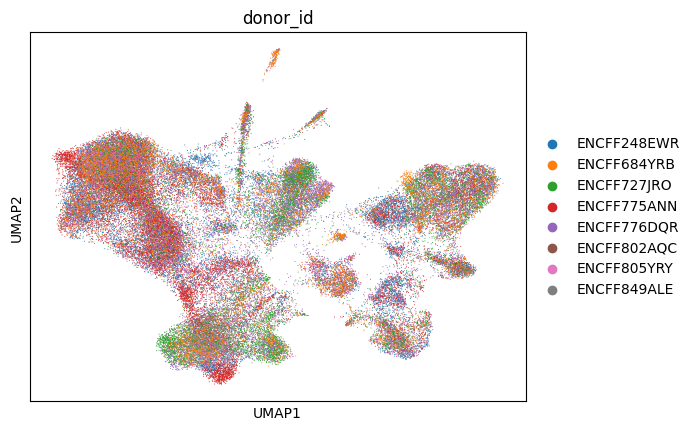

CPU times: user 34min 12s, sys: 2h 31min 37s, total: 3h 5min 49s
Wall time: 4min 23s


In [18]:
%%time
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata,
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

### Identify differentially expressed genes

In [19]:
%%time
sc.tl.rank_genes_groups(adata, groupby="leiden")

CPU times: user 1min 10s, sys: 16.4 s, total: 1min 26s
Wall time: 8.71 s


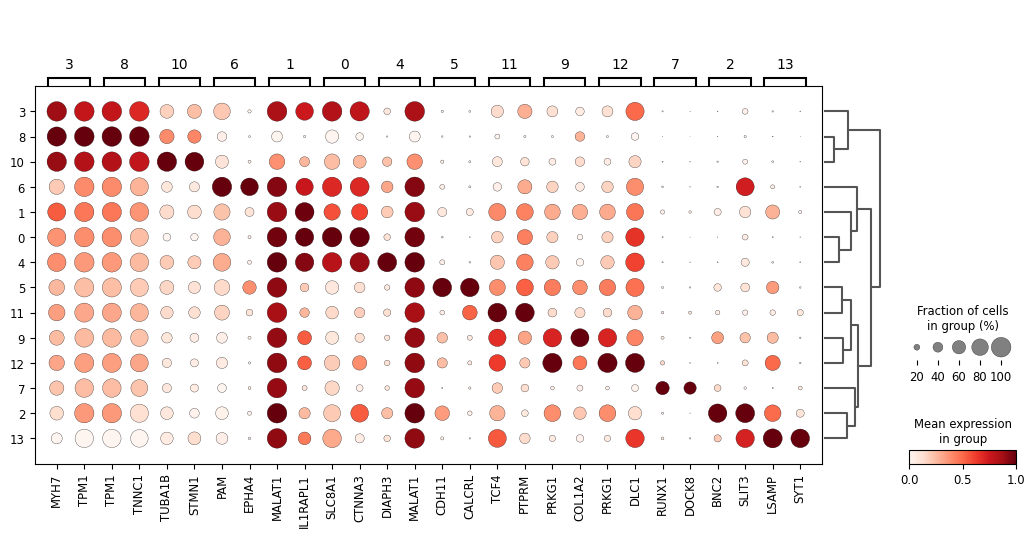

In [20]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=2)

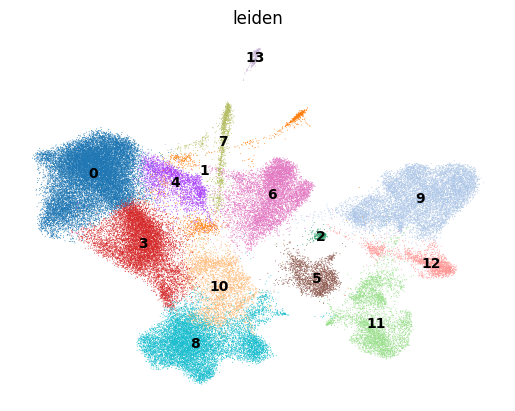

In [22]:
sc.pl.umap(adata, color=["leiden"], legend_loc = "on data",frameon=False)

In [44]:
sc.get.rank_genes_groups_df(adata, group="13").head(30)

,names,scores,logfoldchanges,pvals,pvals_adj
0,LSAMP,37.178280,5.484179,7.068927e-92,1.616776e-89
1,SYT1,34.725716,8.450874,1.214640e-86,2.559015e-84
2,EML5,31.393599,8.734362,3.151793e-79,5.735678e-77
3,ASTN2,29.942289,6.555548,7.629511e-76,1.296135e-73
4,DPP6,29.747862,7.698524,2.243047e-75,3.745634e-73
5,RBFOX1,29.230057,4.432332,3.460992e-74,5.543246e-72
6,MEG3,29.038603,4.459607,9.824223e-74,1.539914e-71
7,CTNNA2,28.933859,8.311192,2.044637e-73,3.171075e-71
8,FGF14,28.775278,6.414454,4.877341e-73,7.465888e-71
9,LINGO2,27.428392,7.963872,1.050355e-69,1.459571e-67


In [45]:
adata.obs["cell_type"] = adata.obs["leiden"].map(
    {
        "0": "Cardiomyocyte",
        "1": "Neuronal",
        "2": "Unclear",
        "3": "Cardiomyocyte",
        "4": "Cardiomyocyte",
        "5": "Endocardial",
        "6": "Unclear",
        "7": "Myeloid",
        "8": "Cardiomyocyte",
        "9": "Fibroblast",
        "10": "Cardiomyocyte",
        "11": "Endothelial",
        "12": "Pericyte",
        "13": "Unclear"
    }
)

In [46]:
# since we annotated it, copy over the cell_type to consistent_cell_type
adata.obs["consistent_cell_type"] = adata.obs["cell_type"]

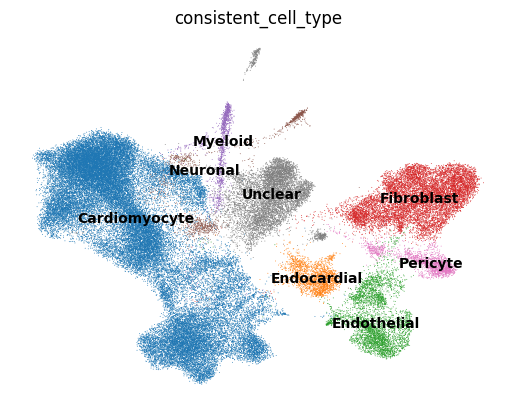

In [47]:
sc.pl.umap(adata, color=["consistent_cell_type"], legend_loc = "on data",frameon=False)

In [48]:
# restore the raw counts
adata.X = adata.layers["counts"]

In [49]:
Counter(adata.obs_names).most_common()[0]

('ENCFF802AQC:AAACAGCCAAGCTACC', 1)

In [50]:
adata.write("02_fetal_ENCODE.h5ad")